## Problem statement 

This study examines how socioeconomic, environmental, and logistical factors affect the accessibility and equity of community programs. It analyzes the impact of socioeconomic status (SES) on program availability, equity-focused features like scholarships and transportation in low-SES areas, the influence of seasonality on program offerings and costs, and how program location and public transportation accessibility shape participation. By identifying where, when, and what programs are available in Chicago, this analysis supports the My CHI. My Future. team in prioritizing community needs, fostering partnerships, and ensuring equitable opportunities for all Chicago youth.

## Data sources


[My Chi. My Future](https://data.cityofchicago.org/Events/My-CHI-My-Future-Programs/w22p-bfyb/about_data)
This dataset provides comprehensive information on all programs under the My Chi. My Future initiative, including key details such as accessibility features, start/end dates, and location. By analyzing various aspects of this dataset, we aim to uncover trends and correlations that address the primary research questions. The version of this dataset used for analysis was downloaded on November 13, 2024.


[Chicago Temperature](https://www.weather.gov/wrh/climate?wfo=lot)
This dataset contains monthly average temperature records for Chicago from 2000 to 2024. It will be used to evaluate the influence of temperature and seasonality on the types and pricing of community programs, particularly focusing on how weather conditions affect program offerings across different age groups (Research Question 3).


[Chicago Census Data](https://data.cityofchicago.org/Health-Human-Services/Per-Capita-Income/r6ad-wvtk)
The hardship index data provides insights into socioeconomic conditions across various Chicago communities, which is crucial for analyzing the relationship between community socioeconomic status and program accessibility (Research Questions 1 and 2).


[CTA Info](https://www.transitchicago.com/data/)
This dataset includes extensive information on Chicago Transit Authority station and bus stop locations. It will be utilized to examine the proximity of community programs to public transportation, helping to understand the effects of accessibility on program participation and the support provided (Research Question 4).

[Chicago Boundaries](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)
The boundaries dataset provides geographical data on Chicago's neighborhoods, which allows for categorizing the different programs in the My Chi. My Future dataset by community area. This categorization is essential for analysis related to community socioeconomic factors and their impact on accessibility (Research Questions 1 and 2).



## Data quality check / cleaning / preparation 


In [ ]:
#| echo: false

# Filter to only the relevant columns used in the analysis
relevant_columns = ['COMMUNITY AREA NAME', 'HARDSHIP INDEX']
census_data_filtered = census_data_df[relevant_columns]

# Function to summarize categorical variables
def summarize_categorical(data, column):
    summary = {}
    summary['Variable'] = column
    summary['Type'] = 'Categorical'
    summary['Missing Values'] = data[column].isna().sum()
    summary['Unique Values'] = data[column].nunique()
    if summary['Unique Values'] > 5:  # Include top 5 levels if too many
        summary['Top Levels'] = data[column].value_counts().nlargest(5).to_dict()
    else:  # Include all levels if few
        summary['Top Levels'] = data[column].value_counts().to_dict()
    return summary

# Function to summarize continuous variables
def summarize_continuous(data, column):
    summary = {}
    summary['Variable'] = column
    summary['Type'] = 'Continuous'
    summary['Missing Values'] = data[column].isna().sum()
    summary['Mean'] = data[column].mean()
    summary['Standard Deviation'] = data[column].std()
    summary['Min'] = data[column].min()
    summary['Max'] = data[column].max()
    summary['Median'] = data[column].median()
    return summary

# Summarize relevant variables
summaries = []
for column in census_data_filtered.columns:
    if census_data_filtered[column].dtype == 'object' or census_data_filtered[column].nunique() < 20:  # Treat as categorical
        summaries.append(summarize_categorical(census_data_filtered, column))
    else:  # Treat as continuous
        summaries.append(summarize_continuous(census_data_filtered, column))

# Convert summaries into a DataFrame for tabular display
summary_df = pd.DataFrame(summaries)

print(tabulate(summary_df, headers='keys', tablefmt='grid'))


+----+---------------------+-------------+------------------+-----------------+--------------------------------------------------------------------------------------------+----------+----------------------+-------+-------+----------+
|    | Variable            | Type        |   Missing Values |   Unique Values | Top Levels                                                                                 |     Mean |   Standard Deviation |   Min |   Max |   Median |
+====+=====================+=============+==================+=================+============================================================================================+==========+======================+=======+=======+==========+
|  0 | COMMUNITY AREA NAME | Categorical |                0 |              78 | {'Rogers Park': 1, 'Pullman': 1, 'Archer Heights': 1, 'Garfield Ridge': 1, 'Hegewisch': 1} | nan      |             nan      |   nan |   nan |      nan |
+----+---------------------+-------------+------------------+---

To address 121,359 missing values in the "Geographic Cluster Name" column for in-person programs in the MCMF dataset, we used geographic information from the Community Boundaries dataset and program latitude-longitude data through two methods. The first method, used in Analysis 1, employed geospatial techniques to map programs to neighborhoods based on latitude and longitude. Missing coordinates were filtered out, valid coordinates were converted into geometric points, and a spatial join assigned each program to a community area. For programs with multiple locations, the most frequent neighborhood name was used to fill missing values.

The second method, used in Analysis 2, standardized and mapped neighborhood names between the datasets. Programs with missing or unstandardized geographic names were matched to neighborhood polygons using spatial operations. Programs with unstandardized names but no geographic data were mapped to the same neighborhoods as others with the same name. To address inconsistencies, we created a new "Neighborhood" column for standardized names, marking programs in unmapped equity zones as "NA."

## Exploratory Data Analysis

### Analysis: How Does Community Socioeconomic Status Relate to the Accessibility of In-Person Programs?
*By \<Gina Valdivia>*

This analysis explores the relationship between community socioeconomic status (SES) and the accessibility of in-person programs across neighborhoods. Using the Hardship Index, a multidimensional measure of socioeconomic conditions, neighborhoods were categorized into Low-SES, Mid-SES, and High-SES. Communities with higher Hardship Index scores face worse economic and social conditions. The study examines program density, type, cost differences, and support features (e.g., scholarships, transportation, and free food) across SES levels through visualizations like bar and scatter plots, as well as a line of best fit to assess correlations between hardship and program availability.

The dataset was filtered to include only in-person programs and merged with socioeconomic data from Chicago Census to provide a complete profile of each community. SES bins were created based on the Hardship Index to classify neighborhoods. Missing data in the "Geographic Cluster Name" column was resolved using geospatial imputation with GeoPandas, matching latitude and longitude coordinates to community area polygons from Chicago Boundaries data. Inconsistent geographic cluster names were standardized by converting text to uppercase and removing extra whitespace to ensure accurate mergin

To assess the impact of community hardship on the number of available programs, we created a scatter plot with a line of best fit between Program Count and the Hardship Index. The Pearson correlation coefficient (r) was -0.240 and P-value was 3.928e-02 for this graph. This p value is under 0.05, and thus indicates that the correlation was statistically significant.


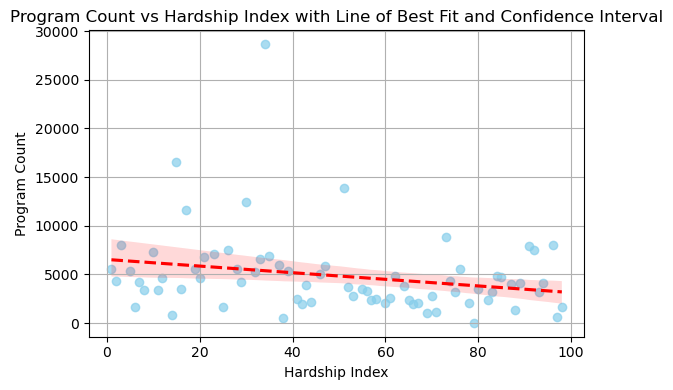

In [ ]:
#| echo: false
# Plotting Hardship Index vs Program Count with a line of best fit including confidence interval
plt.figure(figsize=(5, 3))
sns.regplot(
    data=density_income_df,
    x='HARDSHIP INDEX',
    y='Hardship Program Count',
    ci=95,  # Confidence interval level, default is 95%
    scatter_kws={'color': 'skyblue', 'alpha': 0.7},
    line_kws={'color': 'red', 'linestyle': '--'}
)

plt.xlabel('Hardship Index')
plt.ylabel('Program Count')
plt.title('Program Count vs Hardship Index with Line of Best Fit and Confidence Interval')
plt.grid(True)
plt.tight_layout()
plt.show()


There are a few outliers, which influence the slope of the line of best fit, but the narrow confidence interval suggests that the model is able to explain the data quite precisely for the majority of the points and the outliers' influence is limited. We notice that there is a negative correlation between Hardship Index and Program Count. As hardship increases, the number of programs decreases. The line of best fit shows a clear downward trend, suggesting that higher hardship areas have significantly fewer programs. To further investigate whether the correlations shown in regards to availability of programs, we plotted the Average Program Count by Economic Status using SES bins. When using pd.qcut(), we handled duplicate bin edges by adding duplicates='drop', allowing us to divide data into quantiles without non-unique bins. The bar plot shows high-SES areas have the most programs, while Low-SES areas have the fewest, highlighting resource disparities. We recommend My Chi My Future increase in-person programs in Low-SES areas and enhance outreach to raise awareness in underserved communities.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


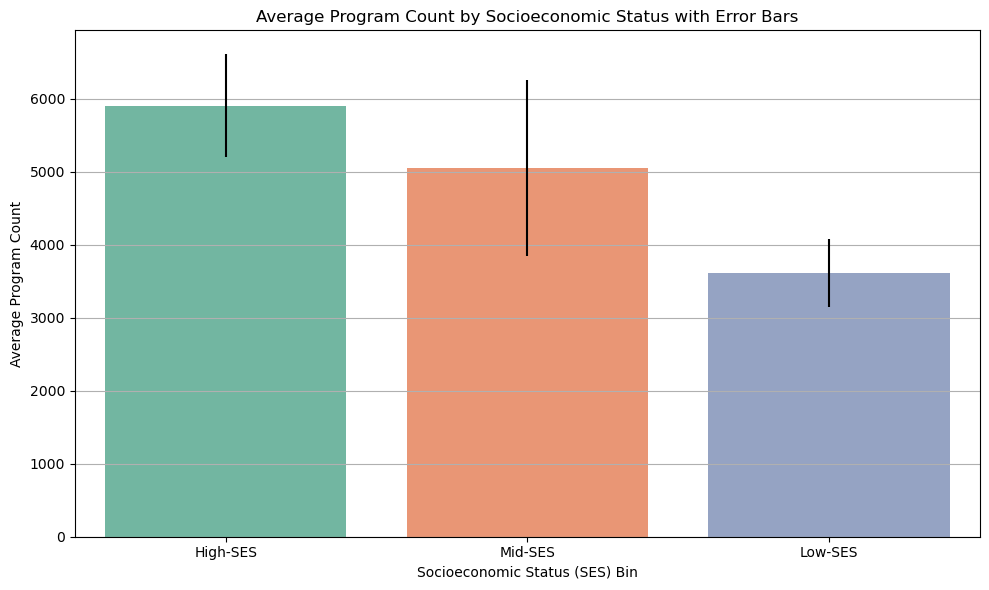

In [ ]:
#| echo: false
# Plotting the average program count by SES Bin with optional error bars
plt.figure(figsize=(5, 3))
sns.barplot(
    data=average_program_count_ses,
    x='ses_bin',
    y='Hardship Program Count',
    order=['High-SES', 'Mid-SES', 'Low-SES'],
    palette='Set2',
    yerr=average_program_count_ses['sem']  # Adding custom error bars representing SEM
)
plt.xlabel('Socioeconomic Status (SES) Bin')
plt.ylabel('Average Program Count')
plt.title('Average Program Count by Socioeconomic Status with Error Bars')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

We analyzed program types and accessibility across SES levels, revealing several important trends and disparities. Sports and Wellness programs dominate all SES categories but are significantly fewer in Low-SES areas, highlighting inequalities in opportunities for well-being where they may be most needed. To assess program accessibility, we evaluated cost, availability of scholarships, paid participation, transportation, and free food, categorizing and plotting them by SES bins.

Free programs are abundant in both Low-SES and High-SES neighborhoods but notably fewer in Mid-SES areas, suggesting these communities may fall between eligibility for assistance programs and the ability to afford other options. Scholarships and transportation support are most prevalent in High-SES areas, followed by Mid-SES and Low-SES, underscoring inequities in resource distribution to underserved neighborhoods. Paid participation programs are most common in High-SES areas, with Low-SES areas having a reasonable number, while Mid-SES neighborhoods have the fewest, pointing to a gap in incentivized opportunities for these communities. Programs offering free food are most available in Low-SES neighborhoods, effectively addressing food insecurity there, but are significantly fewer in Mid- and High-SES areas, suggesting that broader food access needs are not being fully addressed across all SES levels.



## Conclusions

Do the individual analysis connect with each other to answer a bigger question? If yes, explain.

Overall, we found there is a smaller amount of programs in neighborhoods of lower socioeconomic status. Furthermore, Low-SES neighborhoods generally have more access to free programs and food support, but they are underrepresented in terms of transportation assistance and scholarship availability, both of which are crucial for increasing participation. Mid-SES areas are particularly underserved, with notably fewer free programs, scholarships, and paid opportunities compared to other SES groups. These communities often find themselves caught in a gap. In contrast, High-SES areas have the greatest access to scholarships, transportation, and paid opportunities. These disparities point to inequitable access to resources that can hinder community engagement and growth, particularly in Low-SES and Mid-SES neighborhoods.



## Recommendations to stakeholder(s)

To improve program accessibility, we recommend targeted investments in high Hardship Index communities, including mobile initiatives, pop-up events, and partnerships with NGOs to deliver programs directly to underserved areas. Expanding Sports and Wellness programs and diversifying offerings to include arts, education, and skill-building in Low-SES neighborhoods will support holistic development. Increased resources should be allocated to in-person programs in these areas, paired with outreach to raise awareness about opportunities.Mid-SES neighborhoods, often overlooked, would benefit from more free programs, scholarships, and paid opportunities to address gaps in affordability. Transportation support and needs-based scholarships are critical for Low-SES communities, where access remains a barrier despite free food programs. Equitable resource redistribution and community outreach to improve awareness about available support, such as scholarships and transport assistance, would enhance participation across Low-SES and Mid-SES areas.